<a href="https://colab.research.google.com/github/AlisaAlenteva/Iscusstvennye_neyronne_seti/blob/main/6_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [2]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.applications.densenet import DenseNet121
my_model = DenseNet121(include_top = False, input_shape = (32, 32, 3)) 

my_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']             
                                                                                        

In [ ]:
for layer in my_model.layers:
    layer.trainable = False

In [ ]:
tf.keras.datasets.cifar100.load_data(label_mode="fine")

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

In [ ]:
print(x_train.shape,
y_train.shape,
x_test.shape,
y_test.shape,
sep = '\n')

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
X =[]
Y =[]

for img in x_train:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128)
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)
print(x_train[0].shape)

(50000, 32, 32, 1)
(50000, 32, 32, 2)
(32, 32, 3)


In [ ]:
dfeatures = []

for i, sample in enumerate(X[:20000]):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,32,32,3))
  sample = keras.applications.densenet.preprocess_input(sample)
  prediction = my_model.predict(sample)
  prediction = prediction.reshape((1,1,1024))
  dfeatures.append(prediction)
  print(i)
dfeatures = np.array(dfeatures)
print(dfeatures.shape)

Выходные данные были обрезаны до нескольких последних строк (5000).
17500
1/1 [==============================] - 0s 37ms/step
17501
1/1 [==============================] - 0s 29ms/step
17502
1/1 [==============================] - 0s 35ms/step
17503
1/1 [==============================] - 0s 33ms/step
17504
1/1 [==============================] - 0s 34ms/step
17505
1/1 [==============================] - 0s 29ms/step
17506
1/1 [==============================] - 0s 31ms/step
17507
1/1 [==============================] - 0s 32ms/step
17508
1/1 [==============================] - 0s 30ms/step
17509
1/1 [==============================] - 0s 28ms/step
17510
1/1 [==============================] - 0s 36ms/step
17511
1/1 [==============================] - 0s 36ms/step
17512
1/1 [==============================] - 0s 31ms/step
17513
1/1 [==============================] - 0s 28ms/step
17514
1/1 [==============================] - 0s 31ms/step
17515
1/1 [==============================] - 0s 29ms/step
1751

In [ ]:
dfeatures_val = []

for i, sample_val in enumerate(X[25000:30000]):
  sample_val = gray2rgb(sample_val)
  sample_val = sample_val.reshape((1,32,32,3))
  sample_val = keras.applications.densenet.preprocess_input(sample_val)
  prediction_val = my_model.predict(sample_val)
  prediction_val = prediction_val.reshape((1,1,1024))
  dfeatures_val.append(prediction_val)
  print(i)
dfeatures_val = np.array(dfeatures_val)
print(dfeatures_val.shape)


Выходные данные были обрезаны до нескольких последних строк (5000).
2500
1/1 [==============================] - 0s 36ms/step
2501
1/1 [==============================] - 0s 31ms/step
2502
1/1 [==============================] - 0s 33ms/step
2503
1/1 [==============================] - 0s 33ms/step
2504
1/1 [==============================] - 0s 34ms/step
2505
1/1 [==============================] - 0s 33ms/step
2506
1/1 [==============================] - 0s 29ms/step
2507
1/1 [==============================] - 0s 30ms/step
2508
1/1 [==============================] - 0s 28ms/step
2509
1/1 [==============================] - 0s 27ms/step
2510
1/1 [==============================] - 0s 37ms/step
2511
1/1 [==============================] - 0s 29ms/step
2512
1/1 [==============================] - 0s 39ms/step
2513
1/1 [==============================] - 0s 28ms/step
2514
1/1 [==============================] - 0s 33ms/step
2515
1/1 [==============================] - 0s 31ms/step
2516
1/1 [==========

In [ ]:

model_1= Sequential()

model_1.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(1,1,1024)))
model_1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_1.add(UpSampling2D((2, 2)))
model_1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_1.add(UpSampling2D((2, 2)))
model_1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_1.add(UpSampling2D((2, 2)))
model_1.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model_1.add(UpSampling2D((2, 2)))
model_1.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model_1.add(UpSampling2D((2, 2)))
model_1.summary()


model_1.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1, 256)         2359552   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 2, 2, 128)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          1

In [ ]:
model_1.fit(dfeatures, Y[:20000], verbose=1, epochs=50, batch_size = 500, validation_data=(dfeatures_val, Y[25000:30000]), validation_batch_size = 125)

model_1.save('/content/drive/MyDrive/1rabot.h5')

Epoch 1/50
40/40 [==============================] - 8s 33ms/step - loss: 0.0153 - accuracy: 0.6398 - val_loss: 0.0143 - val_accuracy: 0.6642
Epoch 2/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0144 - accuracy: 0.6593 - val_loss: 0.0140 - val_accuracy: 0.6681
Epoch 3/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0139 - accuracy: 0.6687 - val_loss: 0.0138 - val_accuracy: 0.6778
Epoch 4/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0136 - accuracy: 0.6711 - val_loss: 0.0137 - val_accuracy: 0.6729
Epoch 5/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0133 - accuracy: 0.6743 - val_loss: 0.0138 - val_accuracy: 0.6721
Epoch 6/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0129 - accuracy: 0.6775 - val_loss: 0.0139 - val_accuracy: 0.6708
Epoch 7/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0126 - accuracy: 0.6817 - val_loss: 0.0140 - val_accuracy: 0.6638
Epoch 8/50
40

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/1rabot.h5',
                                   custom_objects=None,
                                   compile=True)

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np

def show(path):

  test = img_to_array(load_img(path))
  orig = test.copy()
  test = cv2.resize(test, (32,32))
  test*= 1.0/255
  lab = rgb2lab(test)
  l = lab[:,:,0]
  L = gray2rgb(l)
  L = L.reshape((1,32,32,3))
  L = keras.applications.densenet.preprocess_input(L)

  densepred = my_model.predict(L)
  ab = model.predict(densepred)


  ab = ab*128
  cur = np.zeros((32, 32, 3))
  cur[:,:,0] = l
  cur[:,:,1:] = ab

  imsave('/content/drive/MyDrive/file.jpg', lab2rgb(cur))
  

  imo = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
  imo = cv2.resize(imo, (256, 256))

  im = cv2.imread("/content/drive/MyDrive/file.jpg")
  im = cv2.resize(im, (256, 256))
  pred = np.concatenate((imo, im), axis=1)
  cv2_imshow(pred)

1/1 [==============================] - 0s 253ms/step


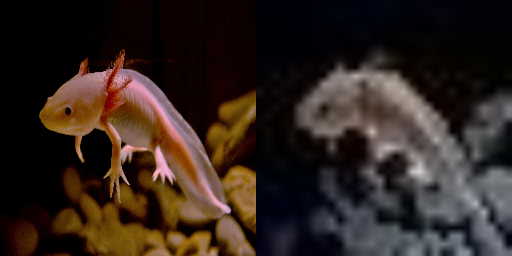

1/1 [==============================] - 0s 19ms/step


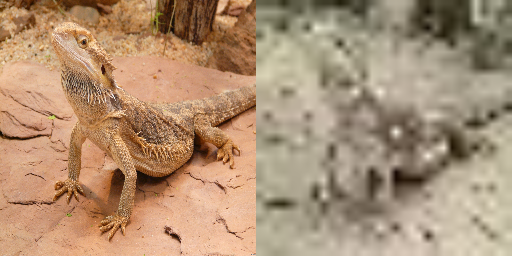

1/1 [==============================] - 0s 32ms/step


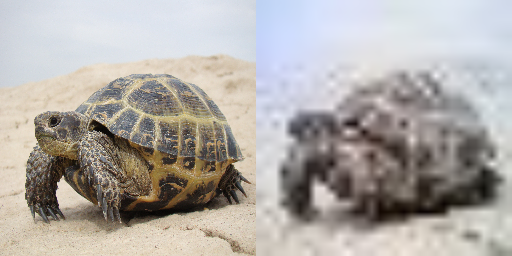

1/1 [==============================] - 0s 30ms/step


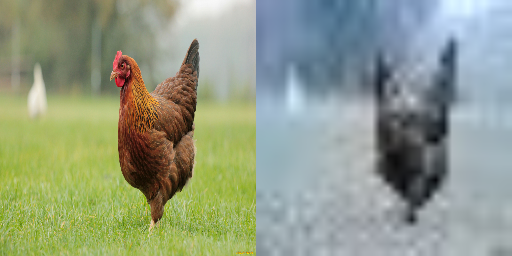

1/1 [==============================] - 0s 27ms/step


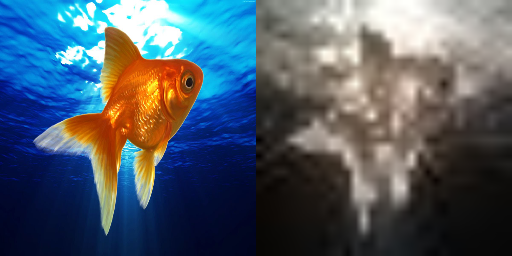

In [ ]:
images = ['/content/drive/MyDrive/class/1.jpg',
          '/content/drive/MyDrive/class/2.jpg',
          '/content/drive/MyDrive/class/3.jpg',
          '/content/drive/MyDrive/class/4.jpg',
          '/content/drive/MyDrive/class/5.jpg']

for i in range(len(images)):
  show(images[i])

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from imutils import paths


def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """
    array = np.array(array, dtype=np.float32)
    array = array / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    n = 8

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(32, 32, 3))
        # plt.show()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(32, 32, 3))
        # plt.show()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
from pathlib import Path

In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/noch/")))
data = []

for imagePath in imagePaths:
  image = cv2.imread(imagePath) # загружаем изображение
  image = cv2.resize(image, (32, 32))
  data.append(image) # добавляем в список

In [ ]:
(train_X, test_X) = train_test_split(data, test_size=0.1, random_state=42)

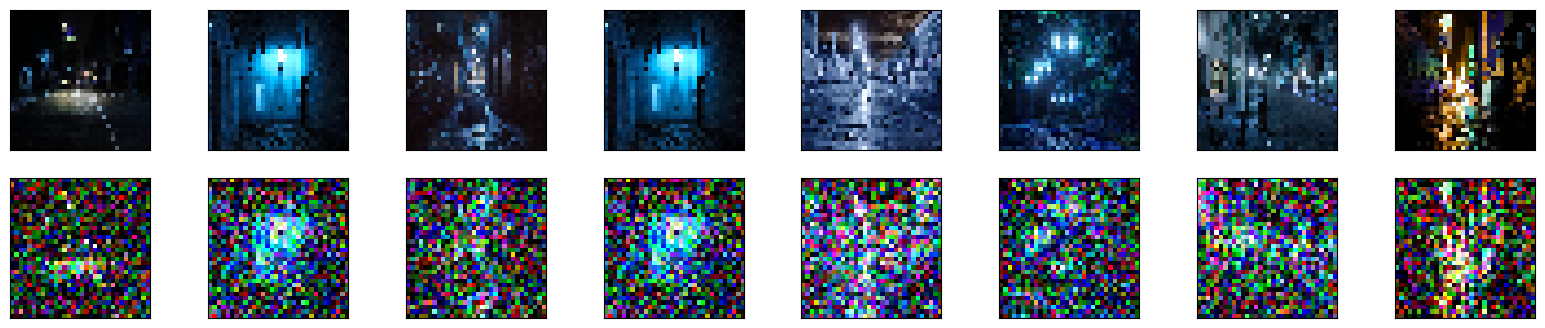

In [ ]:
train_X = preprocess(train_X)
test_X = preprocess(test_X)

noisy_train_X_data = noise(train_X)
noisy_test_X_data = noise(test_X)

display(train_X, noisy_train_X_data)

In [ ]:
train_X.shape

(94, 32, 32, 3)

In [ ]:
test_X.shape

(11, 32, 32, 3)

In [ ]:
noisy_train_X_data.shape

(94, 32, 32, 3)

In [ ]:
noisy_test_X_data.shape

(11, 32, 32, 3)

In [ ]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="linear", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 16)       9232      
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 3)         435       
                                                                 
Total params: 11,459
Trainable params: 11,459
Non-trainable p

In [ ]:
autoencoder.fit(
    x=train_X,
    y=train_X,
    epochs=150,
    batch_size=100,
    shuffle=True,
    validation_data=(test_X, test_X),
)



Epoch 1/150
1/1 [==============================] - 10s 10s/step - loss: 0.0666 - val_loss: 0.0580
Epoch 2/150
1/1 [==============================] - 0s 45ms/step - loss: 0.0606 - val_loss: 0.0521
Epoch 3/150
1/1 [==============================] - 0s 47ms/step - loss: 0.0548 - val_loss: 0.0465
Epoch 4/150
1/1 [==============================] - 0s 44ms/step - loss: 0.0494 - val_loss: 0.0412
Epoch 5/150
1/1 [==============================] - 0s 43ms/step - loss: 0.0444 - val_loss: 0.0366
Epoch 6/150
1/1 [==============================] - 0s 51ms/step - loss: 0.0401 - val_loss: 0.0327
Epoch 7/150
1/1 [==============================] - 0s 41ms/step - loss: 0.0365 - val_loss: 0.0298
Epoch 8/150
1/1 [==============================] - 0s 40ms/step - loss: 0.0340 - val_loss: 0.0278
Epoch 9/150
1/1 [==============================] - 0s 39ms/step - loss: 0.0323 - val_loss: 0.0263
Epoch 10/150
1/1 [==============================] - 0s 39ms/step - loss: 0.0310 - val_loss: 0.0249
Epoch 11/150
1/1 [=

1/1 [==============================] - 0s 116ms/step


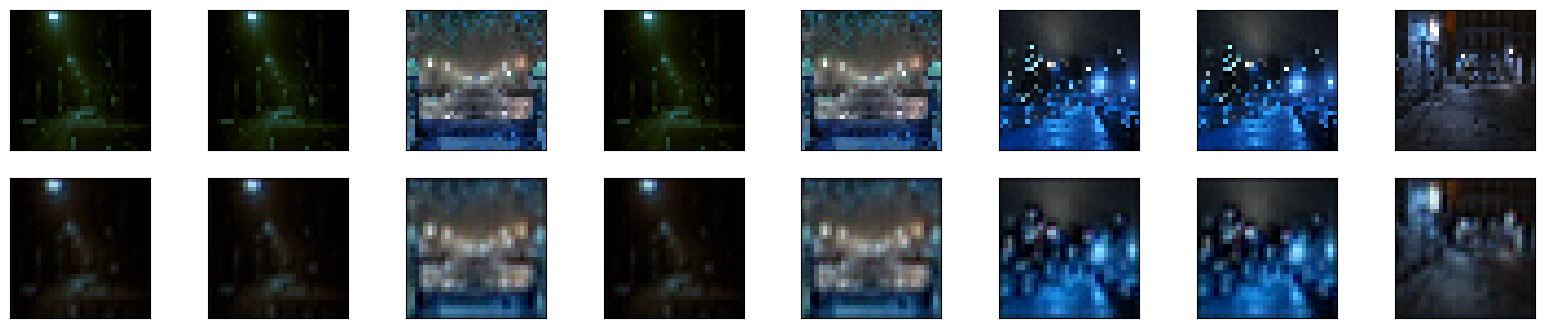

In [ ]:
predictions = autoencoder.predict(test_X)
display(test_X, predictions)

In [ ]:
autoencoder.fit(
    x=noisy_train_X_data,
    y=train_X,
    epochs=100,
    batch_size=100,
    shuffle=True,
    validation_data=(noisy_test_X_data, test_X),
)

Epoch 1/100
1/1 [==============================] - 0s 79ms/step - loss: 0.0331 - val_loss: 0.0234
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0241 - val_loss: 0.0239
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0242 - val_loss: 0.0271
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0274 - val_loss: 0.0272
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0275 - val_loss: 0.0251
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0255 - val_loss: 0.0231
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0237 - val_loss: 0.0223
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0232 - val_loss: 0.0220
Epoch 9/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0231 - val_loss: 0.0216
Epoch 10/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0229 - val_loss: 0.0210
Epoch 11/100
1/1 [=

1/1 [==============================] - 0s 34ms/step


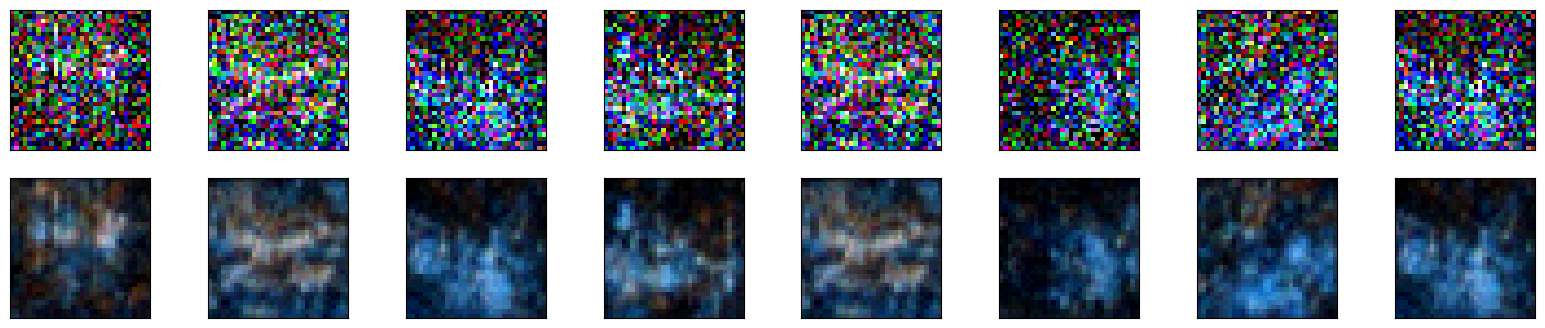

In [ ]:
predictions = autoencoder.predict(noisy_test_X_data)
display(noisy_test_X_data, predictions)

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [136]:
from imutils import paths
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
import os

imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/noch/")))


In [137]:
datas1 = []

for imagePath1 in imagePaths:
  image1 = cv2.imread(imagePath1)
  image1 = cv2.resize(image1, (128, 128))
  datas1.append(image1) 

In [138]:
datas2 = []
for imagePath2 in imagePaths:
  image2 = cv2.imread(imagePath2)
  image2 = cv2.resize(image2, (256, 256))
  datas2.append(image2) 

In [139]:
datas2[0].shape

(256, 256, 3)

In [140]:
datas1[0].shape

(128, 128, 3)

In [141]:
x_train, x_test, y_train, y_test = train_test_split(datas1, datas2, test_size=0.2, random_state=42)

In [142]:
def preprocess1(array1): #Создаем функцию с параметром array1

    array1 = np.array(array1, dtype=np.float32)
    array1 = array1 / 255.0
    array1 = np.reshape(array1, (len(array1), 128, 128, 3))
    return array1

In [143]:
def preprocess2(array2): #Создаем функцию с параметром array2

    array2 = np.array(array2, dtype=np.float32) # Cоздаем массив
    array2 = array2 / 255.0
    array2 = np.reshape(array2, (len(array2), 256, 256, 3)) #Устанавливаем размер
    return array2

In [144]:
x_train = preprocess1(x_train)#помещаем
x_test = preprocess1(x_test)
y_train = preprocess2(y_train)
y_test = preprocess2(y_test)

In [145]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(84, 128, 128, 3)
(84, 256, 256, 3)
(21, 128, 128, 3)
(21, 256, 256, 3)


In [171]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

input1 = layers.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(input1)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="linear", padding="same")(x)


auto = Model(input1, x)
auto.compile(optimizer="adam", loss="mse", metrics = ["mse", "accuracy"])
auto.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_66 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose_67 (Conv2D  (None, 128, 128, 16)     18448     
 Transpose)                                                      
                                                                 
 conv2d_transpose_68 (Conv2D  (None, 256, 256, 32)     4640      
 Transpose)                                                      
                                                          

In [147]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(84, 128, 128, 3)
(84, 256, 256, 3)
(21, 128, 128, 3)
(21, 256, 256, 3)


In [148]:
import tensorflow as tf

In [172]:
history = auto.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=20,
    shuffle=True,
    validation_data = (x_test, y_test),
    )
    

Epoch 1/20
5/5 [==============================] - 2s 163ms/step - loss: 0.0769 - mse: 0.0769 - accuracy: 0.6138 - val_loss: 0.0562 - val_mse: 0.0562 - val_accuracy: 0.5325
Epoch 2/20
5/5 [==============================] - 0s 83ms/step - loss: 0.0675 - mse: 0.0675 - accuracy: 0.6517 - val_loss: 0.0448 - val_mse: 0.0448 - val_accuracy: 0.5032
Epoch 3/20
5/5 [==============================] - 0s 85ms/step - loss: 0.0497 - mse: 0.0497 - accuracy: 0.6193 - val_loss: 0.0244 - val_mse: 0.0244 - val_accuracy: 0.5010
Epoch 4/20
5/5 [==============================] - 0s 86ms/step - loss: 0.0270 - mse: 0.0270 - accuracy: 0.6527 - val_loss: 0.0238 - val_mse: 0.0238 - val_accuracy: 0.5444
Epoch 5/20
5/5 [==============================] - 0s 86ms/step - loss: 0.0242 - mse: 0.0242 - accuracy: 0.6882 - val_loss: 0.0161 - val_mse: 0.0161 - val_accuracy: 0.5387
Epoch 6/20
5/5 [==============================] - 0s 82ms/step - loss: 0.0188 - mse: 0.0188 - accuracy: 0.6765 - val_loss: 0.0160 - val_mse: 0.0

In [173]:
test_img = x_test[0]

test_img = np.reshape(test_img, (1, 128, 128, 3))

In [174]:
test_pred = auto.predict(test_img)

1/1 [==============================] - 0s 82ms/step


In [175]:
test_img = test_img[0,]
test_pred = test_pred[0,]

In [176]:
np.unique(test_pred)

array([-0.05170333, -0.04501232, -0.04052822, ...,  0.9228538 ,
        0.9313525 ,  0.94229186], dtype=float32)

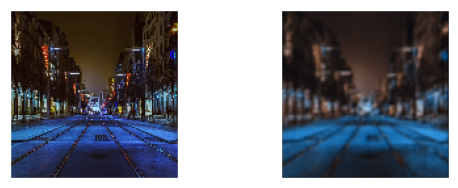

In [177]:
ax = plt.subplot(2, 2, 1)
plt.imshow(test_img)
        # plt.show()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 2, 2)
plt.imshow(test_pred)
        # plt.show()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()